In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os

import sys  

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

## Baseline Metrics

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

(RAPtrain, RAPval, RAPtest,
 RTMAtrain, RTMAval, RTMAtest,
 GOEStrain, GOESval, GOEStest,
 RAOBtrain, RAOBval, RAOBtest) = ml.parition_all(rap=rap, raob=raob, goes=goes, rtma=rtma, 
                                                 percentages=(0.75,0.15,0.10), shuffle=False, seed=1234)

In [4]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [5]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

# Linear

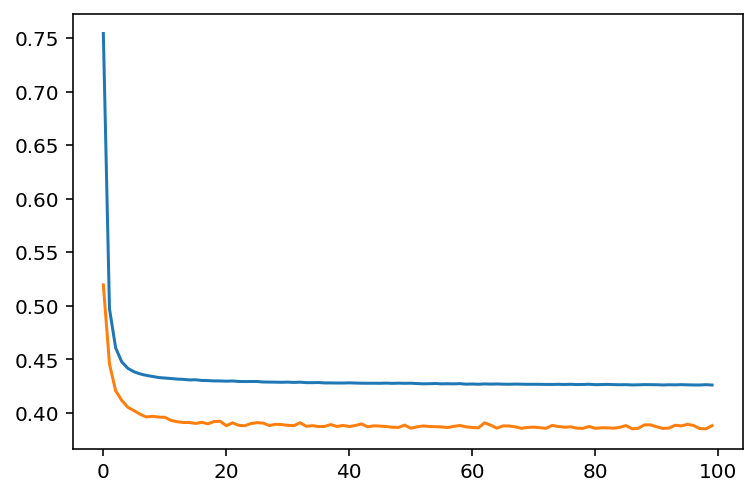

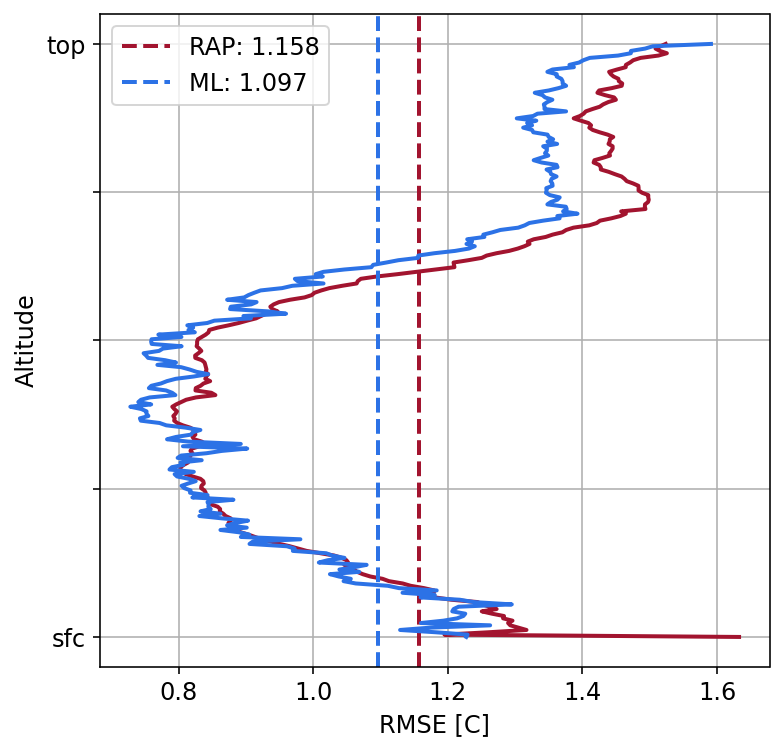

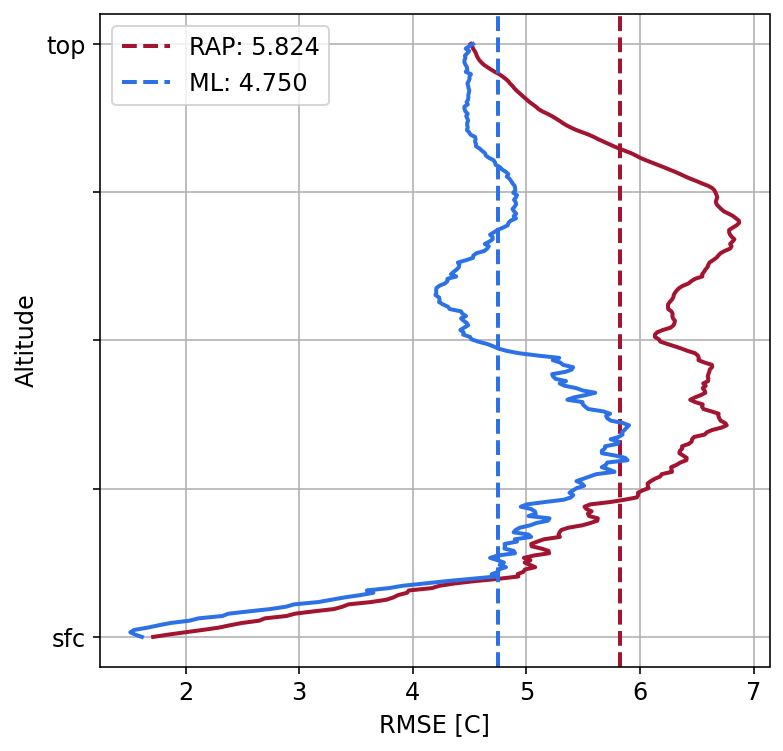

In [7]:
df = pd.read_csv(os.path.join(VOL, 'alley_linear_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [8]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
310,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[0],512,adam,0.0001,None,MAE,100,128,False,False,"[0.5384315848350525, 0.33815300464630127, 0.29...","[0.7541673183441162, 0.497248113155365, 0.4608...","[0.568768322467804, 0.24725566804409027, 0.212...","[0.5384315848350525, 0.33815300464630127, 0.29...","[0.37454554438591003, 0.3049970269203186, 0.27...","[0.5195618271827698, 0.44576188921928406, 0.42...","[0.26994451880455017, 0.19870366156101227, 0.1...","[0.37454554438591003, 0.3049970269203186, 0.27...","[0.8943959621621206, 0.9007917651171699, 0.961...",1.066225,"[0.8943959621621206, 0.9007917651171699, 0.961...",1.026329,"[1.0938166535958098, 1.3003595783372999, 1.405...",4.927718,"[1.0938166535958098, 1.3003595783372999, 1.405...",3.107655,"[0.9262176305678401, 0.9186400424341179, 0.918...",0.980041,"[0.9262176305678401, 0.9186400424341179, 0.918...",0.975819,"[1.1949759788840757, 1.1964436893750001, 1.293...",4.699065,"[1.1949759788840757, 1.1964436893750001, 1.293...",3.211968,"[1.2273282842467073, 1.229276109727186, 1.1826...",1.096661,"[1.2273282842467073, 1.229276109727186, 1.1826...",1.185546,"[1.615812190091477, 1.557970972330886, 1.51448...",4.750354,"[1.615812190091477, 1.557970972330886, 1.51448...",2.870993
214,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[0],512,adam,0.0001,None,MAE,100,128,False,False,"[0.5455870628356934, 0.34122592210769653, 0.30...","[0.766140341758728, 0.5053848028182983, 0.4691...","[0.5869710445404053, 0.2554137706756592, 0.220...","[0.5455870628356934, 0.34122592210769653, 0.30...","[0.37723496556282043, 0.30422478914260864, 0.2...","[0.5255159735679626, 0.4502125382423401, 0.427...","[0.27616703510284424, 0.20269131660461426, 0.1...","[0.37723496556282043, 0.30422478914260864, 0.2...","[0.870917137211884, 0.8880040815650244, 0.9529...",1.062495,"[0.870917137211884, 0.8880040815650244, 0.9529...",1.032684,"[1.0800442216121429, 1.3080679499653143, 1.410...",5.091276,"[1.0800442216121429, 1.3080679499653143, 1.410...",3.101258,"[0.9332778425263499, 0.8934031100929197, 0.913...",0.972696,"[0.9332778425263499, 0.8934031100929197, 0.913...",0.988025,"[1.256332754158335, 1.1778157066402735, 1.2801...",4.815618,"[1.256332754158335, 1.1778157066402735, 1.2801...",3.206483,"[1.2502792344340814, 1.198245459492034, 1.1425...",1.096874,"[1.2502792344340814, 1.198245459492034, 1.1425...",1.215851,"[1.3531946318380925, 1.6143572604475565, 1.553...",4.920945,"[1.3531946318380925, 1.6143572604475565, 1.553...",2.869417
213,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[0],512,adam,0.0001,None,MAE,100,64,False,False,"[0.4526112973690033, 0.29860445857048035, 0.27...","[0.6563752293586731, 0.4672042727470398, 0.451...","[0.43082842230796814, 0.21827982366085052, 0.2...","[0.4526112973690033, 0.29860445857048035, 0.27...","[0.3153027594089508, 0.27295681834220886, 0.25...","[0.4605417549610138, 0.4219203293323517, 0.411...","[0.21209870278835297, 0.1780167669057846, 0.16...","[0.3153027594089508, 0.272

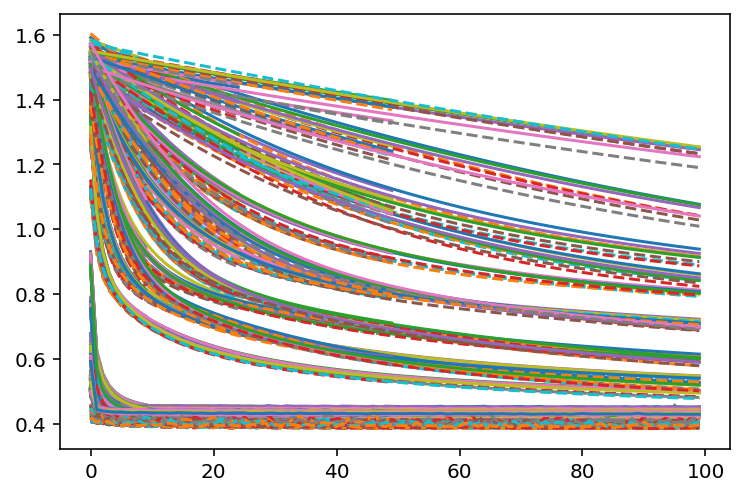

In [9]:
min_i, min_v, max_i, max_v = min_max(df)

# Fully Connected

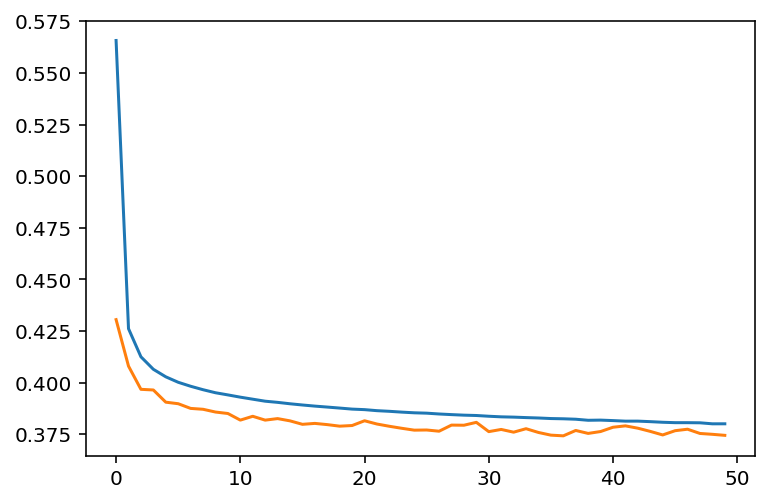

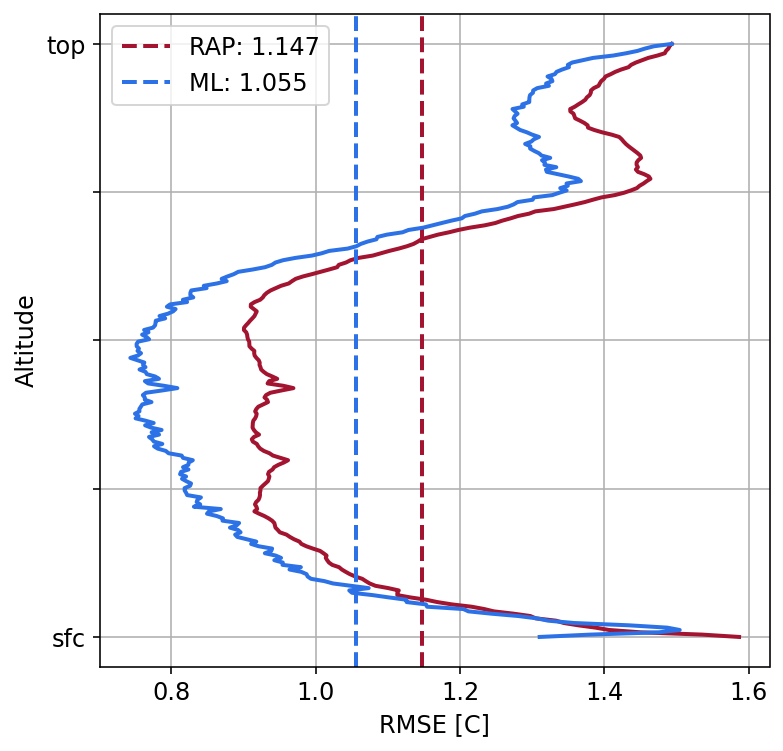

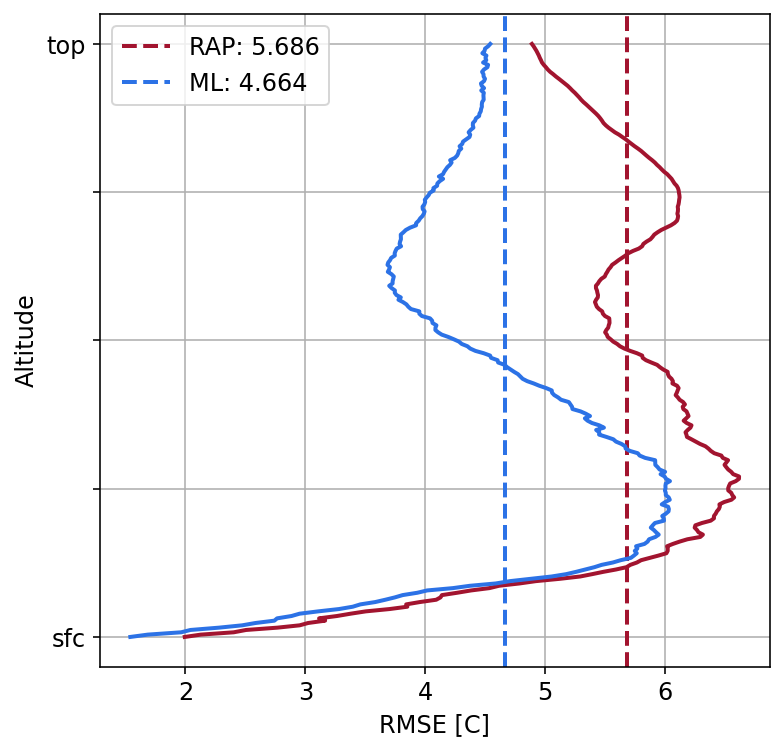

In [9]:
df = pd.read_csv(os.path.join(VOL, 'fully_connected_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [10]:
df.sort_values(['ml_temperature_test_mean_rmse'])[:5]

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_network_inputs,hiddens,n_network_outputs,optim,lr,activ,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
540,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[256],512,adam,0.0001,relu,MAE,50,128,False,False,"[0.38385045528411865, 0.26865336298942566, 0.2...","[0.5656834244728088, 0.4261605441570282, 0.412...","[0.31999772787094116, 0.18161281943321228, 0.1...","[0.38385045528411865, 0.26865336298942566, 0.2...","[0.2809634506702423, 0.25591936707496643, 0.24...","[0.43053188920021057, 0.408023864030838, 0.396...","[0.1853577196598053, 0.16648346185684204, 0.15...","[0.2809634506702423, 0.25591936707496643, 0.24...","[1.2611914935841129, 1.1609282693002692, 1.171...",1.112539,"[1.2611914935841129, 1.1609282693002692, 1.171...",1.072577,"[1.3088378658518207, 1.4687085598137781, 1.577...",4.572751,"[1.3088378658518207, 1.4687085598137781, 1.577...",3.332517,"[1.255121971288057, 1.2033899214156267, 1.1976...",1.055155,"[1.255121971288057, 1.2033899214156267, 1.1976...",1.103898,"[1.4107354139252313, 1.4917685209889986, 1.620...",4.641302,"[1.4107354139252313, 1.4917685209889986, 1.620...",3.297890,"[1.3102828396892086, 1.3801662275474937, 1.475...",1.055166,"[1.3102828396892086, 1.3801662275474937, 1.475...",1.230066,"[1.5399787897131239, 1.685463302257222, 1.9638...",4.664153,"[1.5399787897131239, 1.685463302257222, 1.9638...",3.311616
532,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]",1123,[256],512,adam,0.0001,tanh,MAE,50,128,False,False,"[0.3596090078353882, 0.25736892223358154, 0.24...","[0.5359334349632263, 0.4195473790168762, 0.411...","[0.2872246205806732, 0.17602001130580902, 0.16...","[0.3596090078353882, 0.25736892223358154, 0.24...","[0.26817211508750916, 0.25531819462776184, 0.2...","[0.4206445813179016, 0.40716198086738586, 0.40...","[0.1769418716430664, 0.16578087210655212, 0.16...","[0.26817211508750916, 0.25531819462776184, 0.2...","[1.1821663563434321, 1.1051131861667505, 1.159...",1.121537,"[1.1821663563434321, 1.1051131861667505, 1.159...",1.075774,"[1.31687907200875, 1.4515343947745523, 1.55425...",4.587847,"[1.31687907200875, 1.4515343947745523, 1.55425...",3.367586,"[1.1911234206254153, 1.189956800255319, 1.2760...",1.077420,"[1.1911234206254153, 1.189956800255319, 1.2760...",1.155519,"[1.4288336135576118, 1.4838507512671433, 1.595...",4.663020,"[1.4288336135576118, 1.4838507512671433, 1.595...",3.334667,"[1.249211455576214, 1.3082561673225375, 1.3905...",1.060435,"[1.249211455576214, 1.3082561673225375, 1.3905...",1.211245,"[1.5632696781714626, 1.6478289945777151, 1.916...",4.675962,"[1.5632696781714626, 1.6478289945777151, 1.916...",3.310219
388,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],1051,[256],512,adam,0.0001,tanh,MAE,50,128,False,False,"[0.36089813709259033, 0.26032909750938416, 0.2...","[0.539089560508728, 0.426214337348938, 0.41826...","[0.29061755537986755, 0.18165865540504456, 0.1...","[0.36089813709259033, 0.26032909750938416, 0.2...","[0.2707001566886902, 0.2506241202354431, 0.244...","[0.42624610662460327, 0.4109855592250824, 0.40...","[0.18168573081493378, 0.16890913248062134, 0.1..."

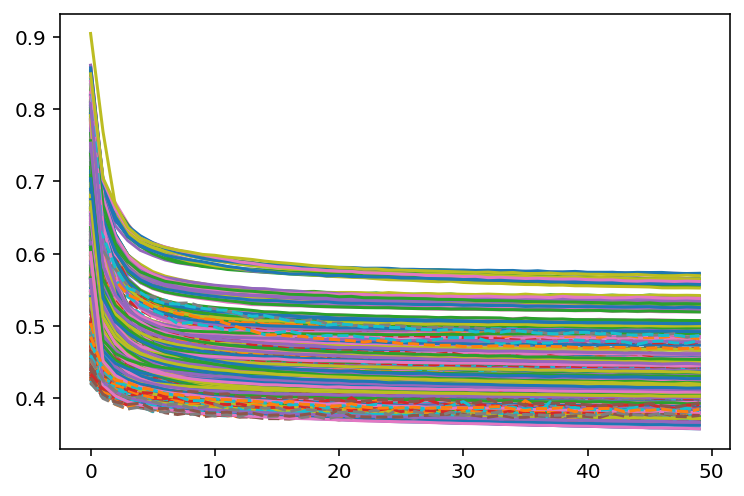

In [11]:
min_i, min_v, max_i, max_v = min_max(df)

# Convolutional

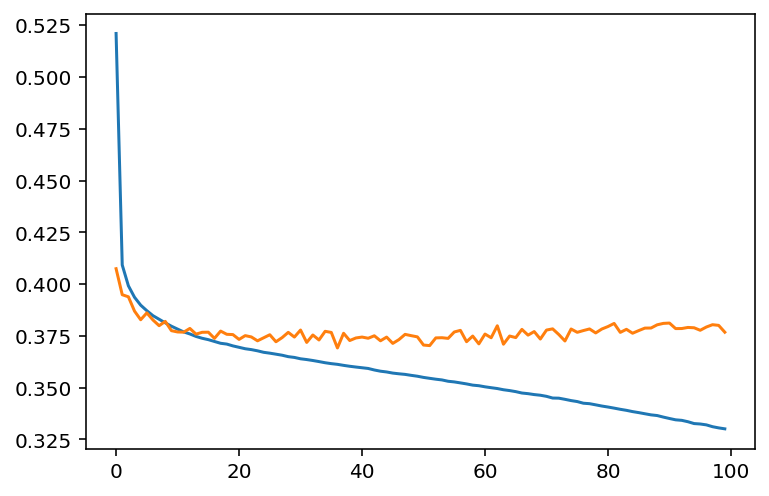

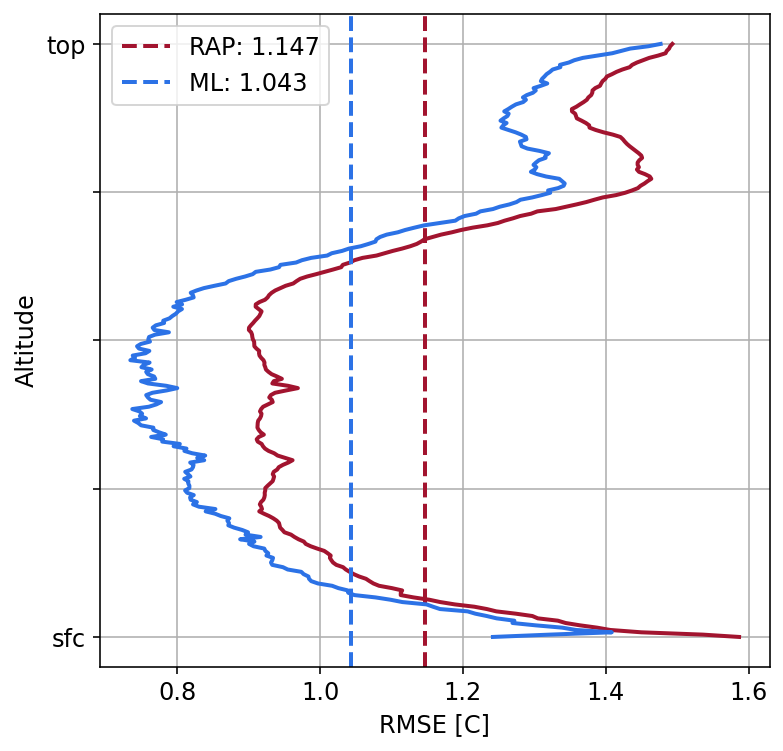

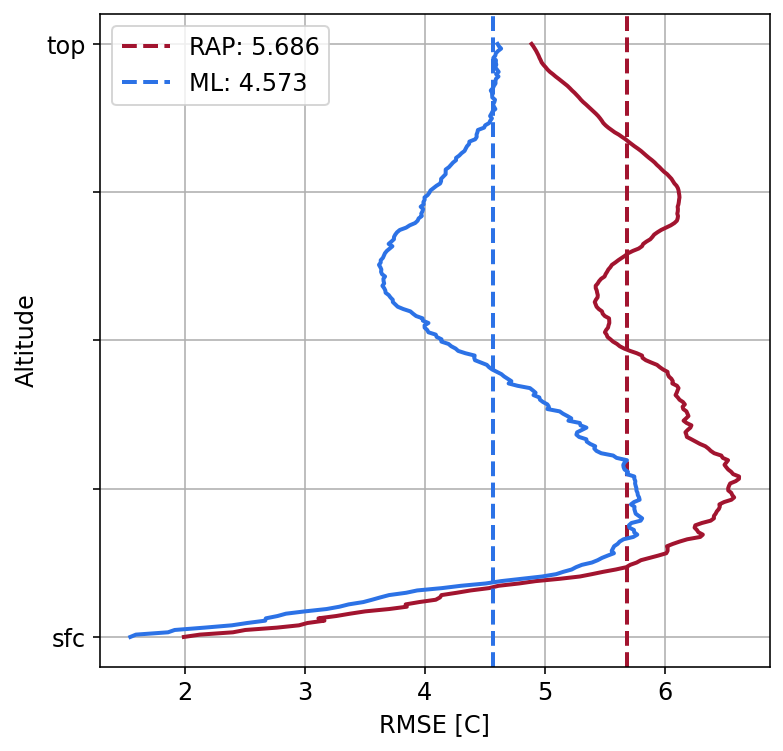

In [12]:
df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [13]:
sorted_df = df.sort_values(['ml_temperature_test_mean_rmse'])
sorted_df.head()

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
46,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.33873793482780457, 0.24832959473133087, 0.2...","[0.5210210084915161, 0.40924733877182007, 0.39...","[0.27146291732788086, 0.1674833744764328, 0.15...","[0.33873793482780457, 0.24832959473133087, 0.2...","[0.25545722246170044, 0.24238446354866028, 0.2...","[0.4074511229991913, 0.39489051699638367, 0.39...","[0.16601644456386566, 0.1559385061264038, 0.15...","[0.25545722246170044, 0.24238446354866028, 0.2...","[1.0865568961153054, 0.9983255764311489, 1.065...",1.054301,"[1.0865568961153054, 0.9983255764311489, 1.065...",0.962382,"[1.185692947604957, 1.308900437137048, 1.40992...",4.061531,"[1.185692947604957, 1.308900437137048, 1.40992...",3.108747,"[1.1528750158696206, 1.0941811266216557, 1.146...",1.036279,"[1.1528750158696206, 1.0941811266216557, 1.146...",1.041449,"[1.3882187812481268, 1.423415336821614, 1.5457...",4.500840,"[1.3882187812481268, 1.423415336821614, 1.5457...",3.165427,"[1.2420395865660205, 1.3215833961994867, 1.408...",1.043325,"[1.2420395865660205, 1.3215833961994867, 1.408...",1.179894,"[1.5478957280291785, 1.594460124191785, 1.8622...",4.572661,"[1.5478957280291785, 1.594460124191785, 1.8622...",3.224224
34,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]",[],"(256, 4)","(3, 3, 3)","[512, 256]",512,"[64, 128, 256]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.3444995880126953, 0.2514580488204956, 0.241...","[0.5280011296272278, 0.4141708016395569, 0.403...","[0.27878519892692566, 0.17153745889663696, 0.1...","[0.3444995880126953, 0.2514580488204956, 0.241...","[0.25958147644996643, 0.24641746282577515, 0.2...","[0.4141853153705597, 0.4004099667072296, 0.393...","[0.1715494692325592, 0.16032813489437103, 0.15...","[0.25958147644996643, 0.24641746282577515, 0.2...","[1.0246923915216628, 0.9611604936586138, 1.005...",1.059850,"[1.0246923915216628, 0.9611604936586138, 1.005...",0.948193,"[1.1863727440387497, 1.3226225411016614, 1.407...",4.346190,"[1.1863727440387497, 1.3226225411016614, 1.407...",3.126715,"[1.1464316379614363, 1.0474892467441952, 1.063...",1.036727,"[1.1464316379614363, 1.0474892467441952, 1.063...",1.017536,"[1.3701946770762998, 1.398780298221395, 1.5364...",4.692354,"[1.3701946770762998, 1.398780298221395, 1.5364...",3.169958,"[1.227455298849411, 1.2616524630895076, 1.3357...",1.051004,"[1.227455298849411, 1.2616524630895076, 1.3357...",1.157500,"[1.5230108669407156, 1.5761041540867509, 1.859...",4.730250,"[1.5230108669407156, 1.5761041540867509, 1.859...",3.217811
44,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[512, 256]",512,"[64, 128, 256, 512]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.3432965576648712, 0.25161364674568176, 0.24...","[0.5257664322853088, 0.4112388789653778, 0.399...","[0

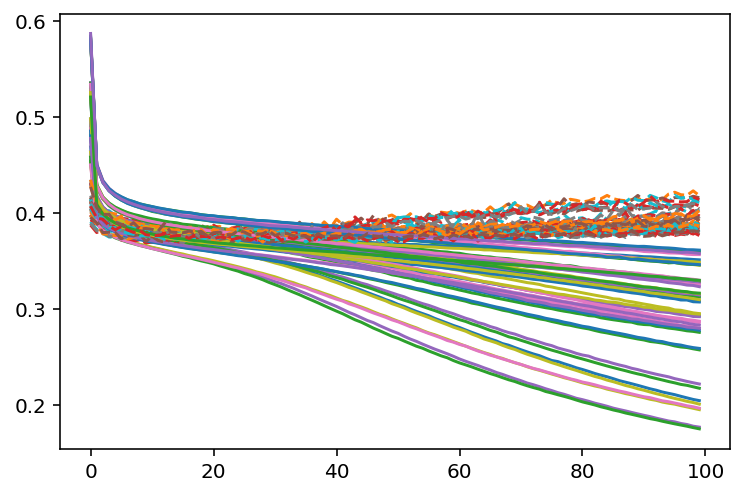

In [14]:
min_i, min_v, max_i, max_v = min_max(df)

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
36,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[2048, 1024]",512,"[64, 128, 256, 512]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,False,"[0.28406235575675964, 0.23179812729358673, 0.2...","[0.45432019233703613, 0.3894079625606537, 0.38...","[0.2064068466424942, 0.15163856744766235, 0.14...","[0.28406235575675964, 0.23179812729358673, 0.2...","[0.24197643995285034, 0.23041726648807526, 0.2...","[0.38768234848976135, 0.379902184009552, 0.383...","[0.1502976268529892, 0.14432567358016968, 0.14...","[0.24197643995285034, 0.23041726648807526, 0.2...","[0.9958942185408938, 0.8756213692393535, 0.881...",0.763474,"[0.9958942185408938, 0.8756213692393535, 0.881...",0.814472,"[1.1253351635891637, 1.1138450261166004, 1.151...",2.492389,"[1.1253351635891637, 1.1138450261166004, 1.151...",2.499356,"[1.2963653639327881, 1.1625869695341893, 1.169...",1.154946,"[1.2963653639327881, 1.1625869695341893, 1.169...",1.104499,"[1.459803580875859, 1.5337618801239317, 1.6390...",4.850692,"[1.459803580875859, 1.5337618801239317, 1.6390...",3.292849,"[1.3149899513885255, 1.3520840871813777, 1.407...",1.175828,"[1.3149899513885255, 1.3520840871813777, 1.407...",1.244397,"[1.6323525060459776, 1.7090045931925184, 1.947...",4.931268,"[1.6323525060459776, 1.7090045931925184, 1.947...",3.395721
37,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)","[2048, 1024]",512,"[64, 128, 256, 512]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,True,"[0.3341395854949951, 0.26697343587875366, 0.25...","[0.49727484583854675, 0.4156726896762848, 0.40...","[0.2472822666168213, 0.17278379201889038, 0.16...","[0.3341395854949951, 0.26697343587875366, 0.25...","[0.2650245726108551, 0.246552512049675, 0.2475...","[0.4116607904434204, 0.3919221758842468, 0.388...","[0.1694646030664444, 0.15360300242900848, 0.15...","[0.2650245726108551, 0.246552512049675, 0.2475...","[1.5772511878583035, 1.1741571235689436, 1.126...",0.969546,"[1.5772511878583035, 1.1741571235689436, 1.126...",1.008782,"[1.5298189141143772, 1.468165714907043, 1.4811...",3.406494,"[1.5298189141143772, 1.468165714907043, 1.4811...",2.860760,"[1.6475473259665663, 1.3548772668682347, 1.302...",1.108642,"[1.6475473259665663, 1.3548772668682347, 1.302...",1.184324,"[1.7322879879864745, 1.6922879559118065, 1.751...",4.628834,"[1.7322879879864745, 1.6922879559118065, 1.751...",3.264838,"[2.010358257087066, 1.7668668606366627, 1.7462...",1.183961,"[2.010358257087066, 1.7668668606366627, 1.7462...",1.470787,"[2.0699267031807462, 1.9768334512300965, 2.147...",4.699303,"[2.0699267031807462, 1.9768334512300965, 2.147...",3.363389


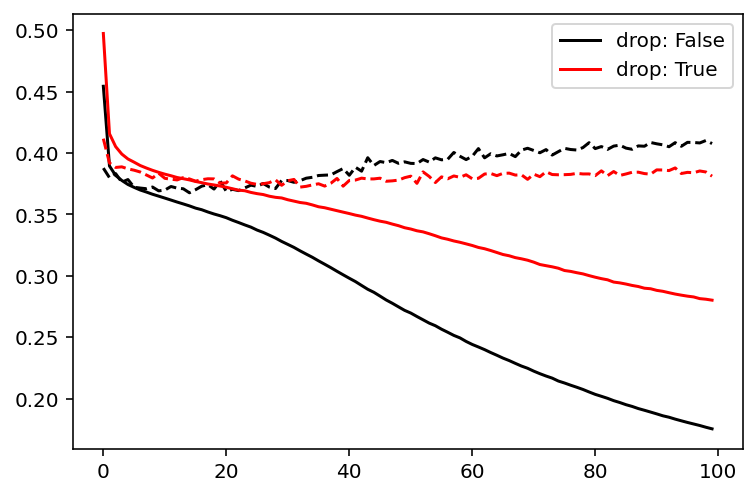

In [81]:
# get same models following first 16 params
filtered_df = df
for k, v in zip(df.iloc[min_i][:17].keys(), df.iloc[min_i][:17].values):
    filtered_df = filtered_df[filtered_df[k] == v]
    
#######

plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'root_mean_squared_error'])), color='k',
         label=f"drop: {filtered_df.iloc[0]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[0][f'val_root_mean_squared_error'])), '--k')

plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'root_mean_squared_error'])), color='r',
         label=f"drop: {filtered_df.iloc[1]['dropout']}")
plt.plot(np.asarray(literal_eval(filtered_df.iloc[1][f'val_root_mean_squared_error'])), 'r')

plt.legend()
filtered_df

,rap_input_dims,rap_output_dims,rtma_input_channels,goes_input_channels,n_rap_inputs,n_im_inputs,hiddens,n_network_outputs,n_units_in_conv_layers,kernels_size_and_stride,rap_activation,dense_activation,optim,lr,loss_f,n_epochs,batch_size,batchnorm,dropout,loss,root_mean_squared_error,mean_squared_error,mean_absolute_error,val_loss,val_root_mean_squared_error,val_mean_squared_error,val_mean_absolute_error,ml_temperature_train_rmse,ml_temperature_train_mean_rmse,ml_temperature_train_rmse_sfc,ml_temperature_train_mean_rmse_sfc,ml_dewpoint_train_rmse,ml_dewpoint_train_mean_rmse,ml_dewpoint_train_rmse_sfc,ml_dewpoint_train_mean_rmse_sfc,ml_temperature_val_rmse,ml_temperature_val_mean_rmse,ml_temperature_val_rmse_sfc,ml_temperature_val_mean_rmse_sfc,ml_dewpoint_val_rmse,ml_dewpoint_val_mean_rmse,ml_dewpoint_val_rmse_sfc,ml_dewpoint_val_mean_rmse_sfc,ml_temperature_test_rmse,ml_temperature_test_mean_rmse,ml_temperature_test_rmse_sfc,ml_temperature_test_mean_rmse_sfc,ml_dewpoint_test_rmse,ml_dewpoint_test_mean_rmse,ml_dewpoint_test_rmse_sfc,ml_dewpoint_test_mean_rmse_sfc
0,"[0, 1, 2, 3]","[1, 2]","[0, 1, 2]","[0, 1, 2, 3, 4, 5, 6, 7]","(256, 4)","(3, 3, 11)",[],512,"[32, 64, 128, 128, 128, 128]","(3, 1)",relu,relu,adam,0.0001,MAE,100,128,False,True,"[0.5022448301315308, 0.3622158169746399, 0.315...","[0.6808104515075684, 0.5111223459243774, 0.464...","[0.4635028839111328, 0.2612460255622864, 0.216...","[0.5022448301315308, 0.3622158169746399, 0.315...","[0.30514031648635864, 0.27240654826164246, 0.2...","[0.4556020498275757, 0.42055872082710266, 0.41...","[0.20757323503494263, 0.17686964571475983, 0.1...","[0.30514031648635864, 0.27240654826164246, 0.2...","[1.3806566985594146, 1.2588919591843808, 1.313...",1.141013,"[1.3806566985594146, 1.2588919591843808, 1.313...",1.151217,"[1.5006757415831309, 1.6391040332931504, 1.702...",4.512691,"[1.5006757415831309, 1.6391040332931504, 1.702...",3.327699,"[1.2773098194627504, 1.2465013391943789, 1.286...",1.118213,"[1.2773098194627504, 1.2465013391943789, 1.286...",1.17442,"[1.5754778722019647, 1.612088918809939, 1.7009...",4.643323,"[1.5754778722019647, 1.612088918809939, 1.7009...",3.322503,"[1.5876472080601496, 1.6611661202437917, 1.783...",1.150549,"[1.5876472080601496, 1.6611661202437917, 1.783...",1.460479,"[1.750244760358427, 1.8203939347563836, 2.0450...",4.693368,"[1.750244760358427, 1.8203939347563836, 2.0450...",3.299503


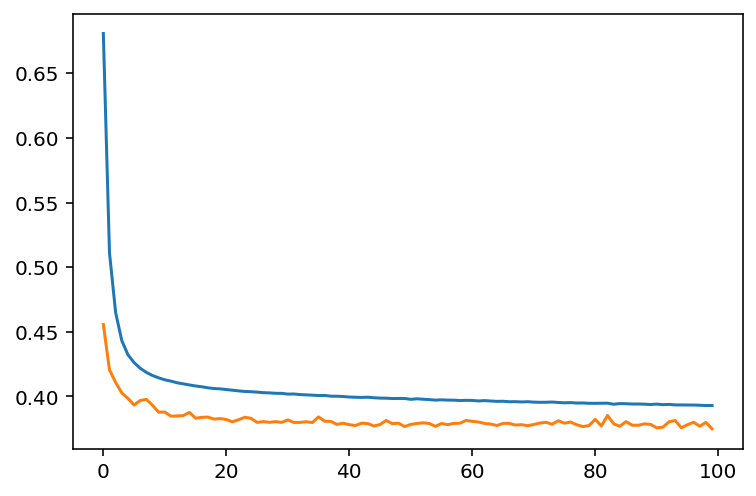

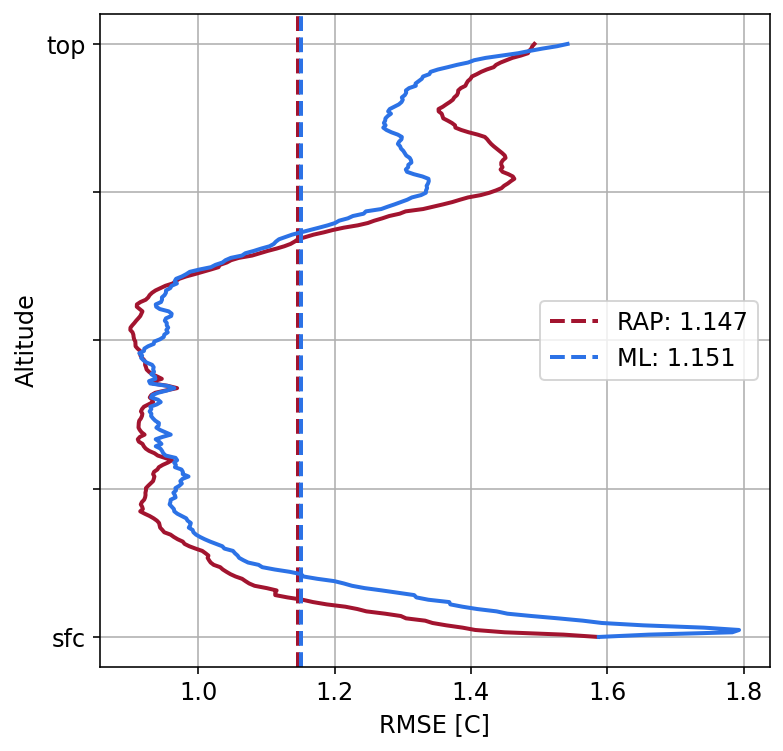

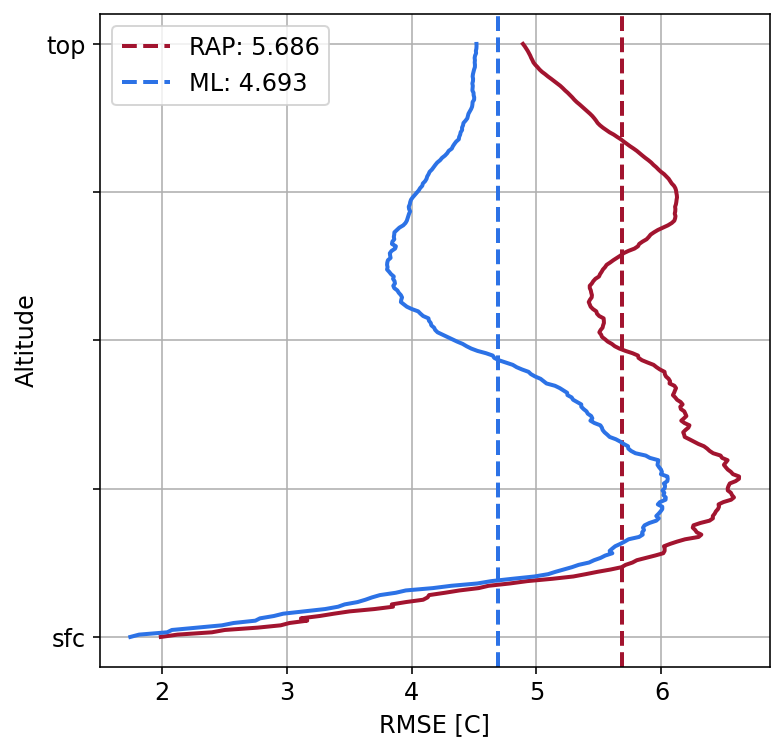

In [16]:
df = pd.read_csv(os.path.join(VOL, 'multi_cnn_model_temperature_dewpoint_regularization.csv'))

i = df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)
    
df.sort_values(['ml_temperature_test_mean_rmse']).head()

## Data Visualizations

In [6]:
locations = dict()

for f in sonde_files:
    content = f.split('_')
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        locations[name] = (lon, lat, locations[name][2] + 1)
    else:
        locations[name] = (lon, lat, 1)
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'count']
df.head(5)

,location,lon,lat,count
0,abr,-98.42,45.45,1457
1,ama,-101.7,35.23,1406
2,bis,-100.75,46.77,1396
3,ddc,-99.97,37.77,1397
4,drt,-100.92,29.37,994


In [10]:
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['lon'],
        lat = df['lat'],
        text = df['location'],
        mode = 'markers',
        marker = dict(
            size = 6,
            opacity = 0.80,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.80,
                color='rgba(75, 75, 75)'
            ),
            colorscale = 'Blues',
            cmin = df['count'].min(), # 0,
            color = df['count'],
            cmax = df['count'].max(),
            colorbar_title='',
            colorbar = dict(
                len = 0.90,
                thickness = 10,
                ticks = 'outside',
                tickcolor = 'black',
                tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
                x = 0.90
            ),
        )))


fig.update_layout(
        geo = dict(
            scope = 'usa',
            projection_type = 'albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(100, 100, 100)",
            countrycolor = "rgb(100, 100, 100)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ), 
        margin=dict(l=0, r=0, t=0, b=5)
    )
fig.show()

fig.write_image('/home/stock/research/media/bubble_map.png', width=450, height=225, scale=4)

## Error Distribution by Month

In [54]:
import glob
import datetime

In [57]:
files = glob.glob('/mnt/data1/stock/mlsoundings/processed/*')

In [69]:
files[:20], months[:20]

(['/mnt/data1/stock/mlsoundings/processed/jan_2020_04_27_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/ilx_2019_05_15_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/ggw_2020_03_05_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/mfl_2020_04_27_1102.nc',
  '/mnt/data1/stock/mlsoundings/processed/shv_2019_10_09_1114.nc',
  '/mnt/data1/stock/mlsoundings/processed/boi_2020_02_19_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/eyw_2020_04_26_2303.nc',
  '/mnt/data1/stock/mlsoundings/processed/drt_2020_02_23_2305.nc',
  '/mnt/data1/stock/mlsoundings/processed/rev_2018_03_05_2310.nc',
  '/mnt/data1/stock/mlsoundings/processed/car_2017_01_18_1102.nc',
  '/mnt/data1/stock/mlsoundings/processed/bmx_2018_05_27_0503.nc',
  '/mnt/data1/stock/mlsoundings/processed/gjt_2019_07_29_1105.nc',
  '/mnt/data1/stock/mlsoundings/processed/jan_2018_05_21_2301.nc',
  '/mnt/data1/stock/mlsoundings/processed/chh_2019_07_25_1132.nc',
  '/mnt/data1/stock/mlsoundings/processed/riw_2018_02_05_1105.

In [68]:
months = np.zeros(len(files))
for i, f in enumerate(files):
    name = f.split('/')[-1]
    name = name[name.find('_')+1:-3]
    months[i] = datetime.datetime.strptime(name, '%Y_%m_%d_%H%M').month

In [ ]:
ind = Xtrain.shape[0]
months = np.zeros(len(Xtest))
# start at offset of Xtest
for i in range(len(Xtest)):
    f = valid_profile_files[ind + i]
    xar = xr.open_dataset(f)
    months[i] = datetime.datetime.strptime(str(xar.base_time.values)[:-3], '%Y-%m-%dT%H:%M:%S.%f').month
    xar.close()
    
    
total_rmse_l = np.zeros(len(Ttest))

for i in range(len(Xtest)):
    Y = nnet.use(Xtest[i:i+1, ...])
    T = Ttest[i:i+1]
    total_rmse_l[i] = ml.rmse(Y, T)
    
monthly_surface_err = []
monthly_total_err = []

for month in np.unique(months):
    monthly_surface_err.append(surface_err[months == month])
    monthly_total_err.append(total_rmse_l[months == month]
    
ind = np.abs(total_rmse_l - total_rmse_l.max()).argmin()
print(f'outlier at index: {ind} has error of: {total_rmse_l[ind]}') 
                             
plot_results(nnet, Xtest, Ttest, 1382, loss=False) #11, 17
                             
                             
radiosonde_plotting.plot_monthly_error(monthly_total_err, months, 'Entire Profile', file_name='../monthly_error');
                             
# remove outlier
monthly_total_err[6] = np.delete(monthly_total_err[6], 
                                 np.abs(monthly_total_err[6] - monthly_total_err[6].max()).argmin())